# Dual CRISPR Screen Analysis
# Ultimate Method 2 WITH CHANGES

Roman Sasik, CCBB, UCSD (rsasik@ucsd.edu)

Amanda Birmingham, CCBB, UCSD (abirmingham@ucsd.edu)

## Instructions

To run this notebook reproducibly, follow these steps:
1. Click **Kernel** > **Restart & Clear Output**
2. When prompted, click the red **Restart & clear all outputs** button
3. Fill in the values for your analysis for each of the variables in the [Input Parameters](#input-parameters) section
4. Click **Cell** > **Run All**

<a name = "input-parameters"></a>

## Input Parameters

In [1]:
g_timestamp = ""
g_scoring_run_prefix = ""
g_scoring_alg_name = "method2ultimate"
g_project_name = "A549_CV4_3-14-21-28_NA_combined_simple-null-w-lfdr"
g_counts_fp = "/Users/Birmingham/Desktop/A549_CV4_counts_w_everything.txt"
g_day_timepoints_str = "3,14,20,28"
g_abundance_thresholds_str = "-19.,-18.5,-18.5,-19.,-19.,-19.,-19.,-19."
g_num_iterations = 1000
g_code_location = "/Users/Birmingham/Repositories/ccbb_tickets/20160210_mali_crispr/src/python"
g_cran_repo ='http://cran.us.r-project.org'

# Note: a list of CRAN mirror sites is at https://cran.r-project.org/mirrors.html

## R Magic Import

In [2]:
%load_ext rpy2.ipython

## CCBB Library Imports

In [3]:
import sys
sys.path.append(g_code_location)

## Automated Set-Up

In [4]:
# %load -s describe_var_list /Users/Birmingham/Repositories/ccbb_tickets/20160210_mali_crispr/src/python/ccbbucsd/utilities/analysis_run_prefixes.py
def describe_var_list(input_var_name_list):
    description_list =  ["{0}: {1}\n".format(name, eval(name)) for name in input_var_name_list]
    return "".join(description_list)


In [5]:
from ccbbucsd.utilities.analysis_run_prefixes import check_or_set, get_run_prefix, get_timestamp
g_timestamp = check_or_set(g_timestamp, get_timestamp())
g_scoring_run_prefix = check_or_set(g_scoring_run_prefix, 
    get_run_prefix(g_project_name, g_scoring_alg_name, g_timestamp))
print(describe_var_list(['g_timestamp', 'g_scoring_run_prefix']))

g_timestamp: 20160826165244
g_scoring_run_prefix: A549_CV4_3-14-21-28_NA_combined_simple-null-w-lfdr_method2ultimate_20160826165244



In [6]:
# TODO: set up handling of customizable output dir(s)

# from ccbbucsd.utilities.files_and_paths import verify_or_make_dir
# verify_or_make_dir(g_collapsed_counts_dir)
# verify_or_make_dir(g_combined_counts_dir)
# verify_or_make_dir(g_plots_dir)

In [7]:
from rpy2.robjects import r
import rpy2.robjects as robjects

gR = robjects.r
# 'temp' assignments suppress printing of cruft stdout
temp = gR.assign('project', g_project_name)
temp = gR.assign('input_filename', g_counts_fp)
temp = gR.assign('niter', g_num_iterations)
temp = gR.assign('g_time_str', g_day_timepoints_str)
temp = gR.assign('g_abundance_str', g_abundance_thresholds_str)
temp = gR.assign('g_cran_repo_url', g_cran_repo)

## R Script

In [8]:
import warnings
with warnings.catch_warnings():
    # NB: rpy2 spits a lot of status messages about installation
    # as "warnings".  The below filter line can be commented out 
    # if you aren't scared of seeing them :)
    warnings.simplefilter("ignore")
    
    %R install.packages("MASS", repos=g_cran_repo_url)
    %R library(MASS)
    
    %R install.packages("locfdr", repos=g_cran_repo_url)
    %R library(locfdr)
    
    %R source("http://bioconductor.org/biocLite.R")
    %R biocLite("qvalue", suppressUpdates=TRUE)
    %R library(qvalue)

In [9]:
%%R

Var<-function(x) mean(x^2)-mean(x)^2 #scalar version
vVar<-function(x) apply(x^2,1,mean)-apply(x,1,mean)^2 #vector version

Cov<-function(x,y) mean(x*y)-mean(x)*mean(y)
vCov<-function(x,y) apply(t(x)*y,2,mean)-apply(x,1,mean)*mean(y) #x is a matrix and y is a vector

sqrtsum<-function(y) sqrt(sum(y^2))

#iterative robust least squares
irls<-function(fc,w0,probes,ag=2,tol=1e-3,maxiter=30) {
# w0 is the physical goodness of constructs. It is not subject to change.
# It is used to modify w, to silence bad constructs 

   expressed_utri<-upper.tri(fc) & w0>0
   n<-dim(fc)[1]
   w<-matrix(1,nrow=n,ncol=n) #initial weights
   diag(w)<-0
   fij<-matrix(0,nrow=n,ncol=n) #initial weights
   eij<-matrix(0,nrow=n,ncol=n) #initial weights
   b<-rep(0,n) #rhs

   #iteration step 0
   w<-w*w0
   A<-w
   for (i in 1:n) {
      b[i]<-sum(fc[,i]*w[,i])
      A[i,i]<-sum(w[,i])+small
   }
   y<-solve(A,b)
   names(y)<-probes
   for (i in 1:(n-1)) {
      for (j in (i+1):n) {
         fij[i,j]<-y[i]+y[j]
      }
   }
   fij<-fij+t(fij)
   eij<-fc-fij #residuals

   l<-1 #counter
   rel<-1
   while (rel > tol & l < maxiter) {#iterate until tol is reached or maxit
      s<-sd(eij[expressed_utri]) #calculate sd only from expressed constructs
      yold<-y

      w<-(1-eij^2/(ag*s)^2)^2 #something like Tukey's biweight
      w[abs(eij)>(ag*s)]<-0
      diag(w)<-0

      w<-w*w0

      A<-w
      for (i in 1:n) {
         b[i]<-sum(fc[,i]*w[,i])
         A[i,i]<-sum(w[,i])+small
      }
      y<-solve(A,b)
      names(y)<-probes
      fij<-matrix(0,nrow=n,ncol=n) #initial weights
      for (i in 1:(n-1)) {
         for (j in (i+1):n) {
            fij[i,j]<-y[i]+y[j]
         }
      }
      fij<-fij+t(fij)
      eij<-fc-fij #residuals

      rel<-sqrt(sum((y-yold)^2)/max(1,sum(yold^2))) #relative error
      cat(l,sqrtsum(yold),sqrtsum(y-yold),"\n") # AB Ok, it's printing something here ...
      l<-l+1
   }
   vl<-list(y, fij, eij)
   return(vl)
}

In [10]:
#%%R

#pdf(paste(project,".pdf",sep=""))
#par(pty="s",mfrow=c(1,1))

In [11]:
%R X<-read.table(input_filename,sep="\t",header=TRUE)

,construct_id,probeA,probeB,geneA,geneB,A549_CV4_d3_1_S1_trimmed53_len_filtered_counts,A549_CV4_d3_2_S2_trimmed53_len_filtered_counts,A549_CV4_d14_1_S3_trimmed53_len_filtered_counts,A549_CV4_d14_2_S4_trimmed53_len_filtered_counts,A549.CV4.d21.1_S3_trimmed53_len_filtered_counts,A549.CV4.d21.2_S4_trimmed53_len_filtered_counts,A549.CV4.d28.1_S5_trimmed53_len_filtered_counts,A549.CV4.d28.2_S6_trimmed53_len_filtered_counts
1,ABL1_chr9_133589790__ADA_chr20_43257696,ABL1_chr9_133589790,ADA_chr20_43257696,ABL1,ADA,226,187,153,459,69,303,40,167
2,ABL1_chr9_133589790__ADA_chr20_43257769,ABL1_chr9_133589790,ADA_chr20_43257769,ABL1,ADA,208,271,320,123,155,174,157,285
3,ABL1_chr9_133589790__ALK_chr2_29541172,ABL1_chr9_133589790,ALK_chr2_29541172,ABL1,ALK,297,259,384,65,322,28,531,31
4,ABL1_chr9_133589790__ALK_chr2_30143522,ABL1_chr9_133589790,ALK_chr2_30143522,ABL1,ALK,231,277,686,49,1837,82,3620,32
5,ABL1_chr9_133589790__ARID1A_chr1_27056288,ABL1_chr9_133589790,ARID1A_chr1_27056288,ABL1,ARID1A,415,895,246,410,535,262,431,633
6,ABL1_chr9_133589790__ARID2_chr12_46205318,ABL1_chr9_133589790,ARID2_chr12_46205318,ABL1,ARID2,412,569,386,366,403,182,345,433
7,ABL1_chr9_133589790__ARID2_chr12_46254608,ABL1_chr9_133589790,ARID2_chr12_46254608,ABL1,ARID2,257,151,540,331,293,349,398,163
8,ABL1_chr9_133589790__ATM_chr11_108098350,ABL1_chr9_133589790,ATM_chr11_108098350,ABL1,ATM,339,494,408,67,223,252,249,292
9,ABL1_chr9_133589790__ATM_chr11_108098390,ABL1_chr9_133589790,ATM_chr11_108098390,ABL1,ATM,180,75,80,170,36,211,11,268
10,ABL1_chr9_133589790__BCL2_chr18_60795945,ABL1_chr9_133589790,BCL2_chr18_60795945,ABL1,BCL2,313,350,129,336,89,244,92,387


In [12]:
%%R
 
commaSepStringToNumVector<-function(commaSepString){
    strVector = unlist(strsplit(commaSepString, ",", fixed=TRUE))
    return(as.numeric(strVector))
}

time = commaSepStringToNumVector(g_time_str)
ab0 = commaSepStringToNumVector(g_abundance_str)

In [13]:
%%R 

small<-1e-6
nt<-length(time) #nt >= 2
mt<-mean(time)
vt<-Var(time)

## Preparation of Input Data Frame

In [14]:
%%R 

data<-data.matrix(X[,6:(5+2*nt)]) #AB WTHeck are these magic numbers? # AB Argh, this variable is never used!
# AB Best guess: Ignore first 5 columns, assume you want all remaining columns, of which 
# AB you expect two per timepoint

# AB Does this really reject anything with "two 0's"?  
# AB Not exactly; it throws out any rows in the matrix where 
# AB the first and second genes are the same (even if they aren't both 0)
good<-(X$geneA != X$geneB) #reject any constructs with two 0's
goodX<-X[good,] #the 0-0 constructs are gone
nn<-sum(good) #this many constructs # AB GLOBAL

In [15]:
%%R 

# AB This cell does the exact same thing once for A probes and once for B probes
# AB Find any probe name that includes "NonTargeting" and paste a 0 at the beginning of its name
cpA<-as.character(goodX$probeA)
ix<-grep("NonTargeting",cpA)
cpA[ix]<-paste("0",cpA[ix],sep="") #this puts NonTargeting probes at the beginning of alphabetically sorted order

cpB<-as.character(goodX$probeB)
ix<-grep("NonTargeting",cpB)
cpB[ix]<-paste("0",cpB[ix],sep="")

In [16]:
%%R 

# AB So ... Find constructs for which probe A comes later in 
# AB alphabet than B probe and swap them around so that A 
# AB becomes B, such that now all constructs have A probe 
# AB earlier in alphabet than B probe

pswitch<-cpA>cpB #need to switch?
phold<-cpA[pswitch]
cpA[pswitch]<-cpB[pswitch]
cpB[pswitch]<-phold #cpA and cpB are always in alphabetical order, cpA < cpB

probes<-sort(unique(c(cpA,cpB))) #entire probe set in alphabetical order # AB GLOBAL
nprobes<-length(probes) # AB GLOBAL

In [17]:
%%R 

cgA<-as.character(goodX$geneA)
cgB<-as.character(goodX$geneB)
genes<-sort(unique(cgA)) #should be 74 "genes" # AB Depends on library ... but not checked so ok.  # AB GLOBAL
n<-length(genes) # n = 74 if doing it by genes or 222 if doing it by probe # AB GLOBAL
mm<-n*(n-1)/2 # AB What does mm stand for? # AB It seems this is assigned but never used??

In [18]:
%%R 

# AB Doing the same thing as above for probes:
# AB Where necessary, swap gene A and gene B
# AB such that now all constructs have gene A
# AB earlier in alphabet than gene B

gswitch<-cgA>cgB #need to switch?
ghold<-cgA[gswitch]
cgA[gswitch]<-cgB[gswitch]
cgB[gswitch]<-ghold

gA_gB<-paste(cgA,cgB,sep="_")
pA_pB<-paste(cpA,cpB,sep="_") # AB GLOBAL
goodX<-data.frame(goodX,cgA,cgB,gA_gB) #now gA_gB is ordered so that gA < gB

In [19]:
%%R 

# AB get only the "good" rows of only the relevant columns
# AB columns of data.  NB: repeat of magic numbers
gooddata<-data.matrix(goodX[,6:(5+2*nt)])

# AB Add pseudocount--ONLY to the counts that are ZERO
gooddata[gooddata==0]<-1 #pseudocounts

# AB Sum each column to get abundance
abundance<-apply(gooddata,2,sum)
y<-t(log2(t(gooddata)/abundance)) #log2 frequencies # AB GLOBAL

## Histogram Plotting

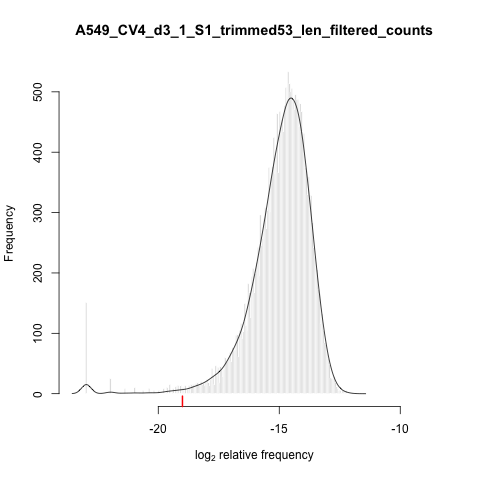

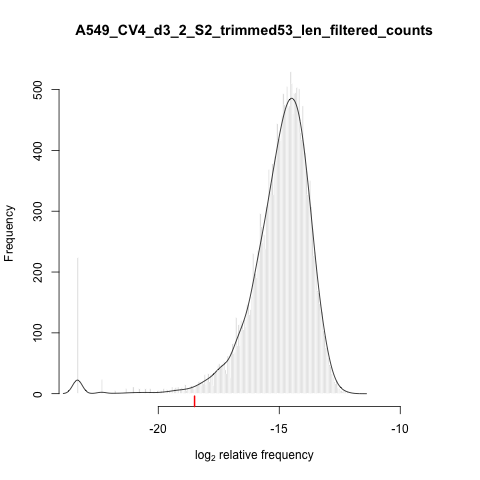

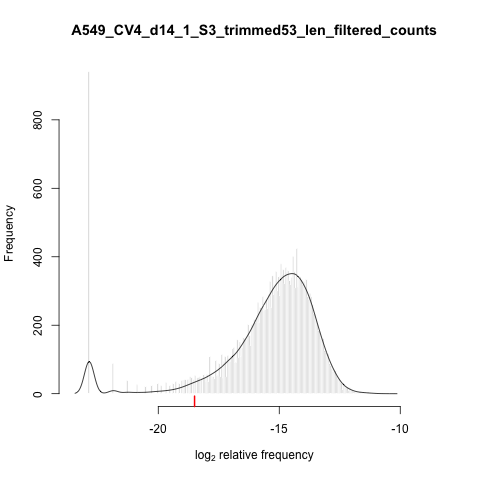

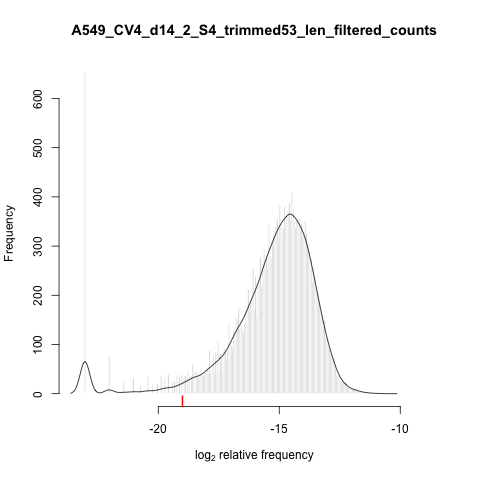

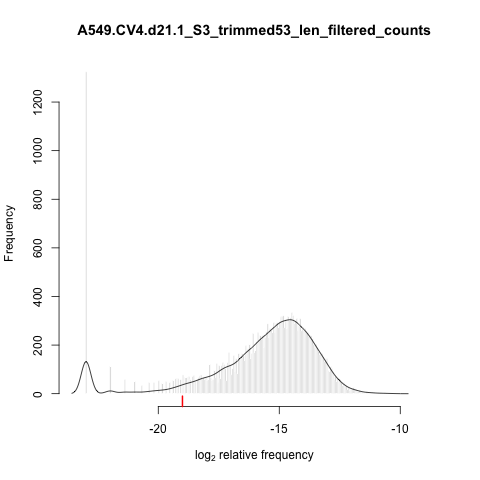

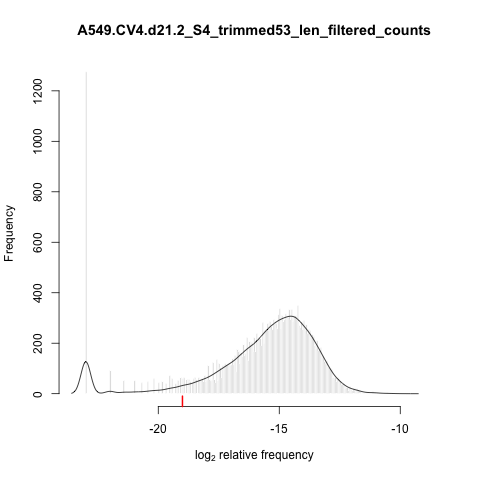

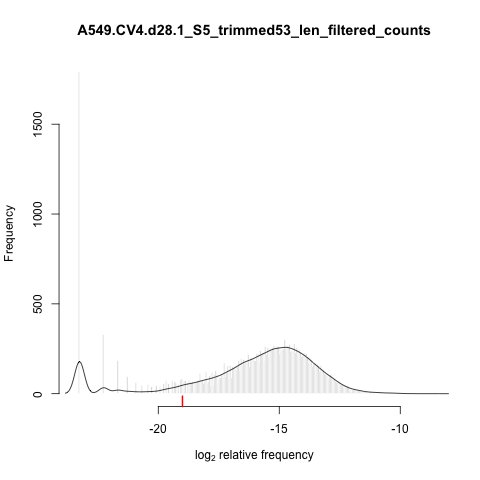

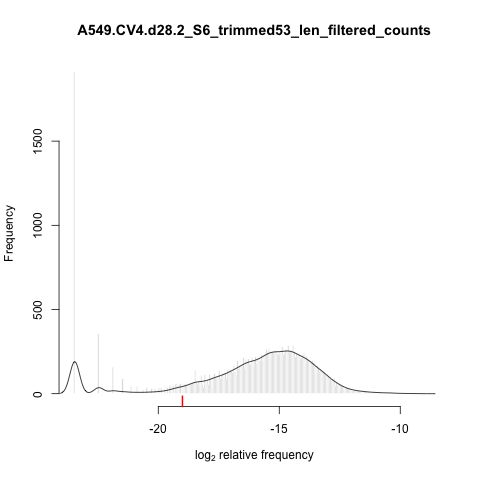

In [20]:
%%R 

# AB remember: y is log2 frequencies of counts with pseudo added ONLY to zeros
# AB i is sample (i.e., timepoint+replicate)
# AB in "density", bw is "the smoothing bandwidth to be used"
# AB (https://stat.ethz.ch/R-manual/R-patched/library/stats/html/density.html)

# AB Why is the ticked part of the x axis so small?

rge<-range(y)
for (i in 1:(2*nt)) {
   h<-hist(y[,i],breaks=seq(rge[1]-0.05,rge[2]+0.05,by=0.05),
        main=colnames(y)[i],xlab=expression(paste(log[2]," relative frequency")),
        col="grey80",border=FALSE)
   d<-density(y[,i],bw=0.2)
    # AB What exactly is  d$y*sum(h$counts)*0.05 ?
   lines(d$x,d$y*sum(h$counts)*0.05,col="black")
    
    # AB lwd = line width
    # AB This adds the little red tick at the abundance threshold
   rug(ab0[i],col="red",lwd=2)
}

## Determining Which Constructs Fail Abundance Threshold

In [54]:
%%R 

# AB This cell does the exact same thing once for each replicate
# AB remember: y is log2 frequencies of counts with pseudo added ONLY to zeros
x1<-y[,seq(1,2*nt,by=2)] # AB 1 column of log2 frequency values for each 1st replicates
ab1<-ab0[seq(1,2*nt,by=2)] # AB vector of abundance threshold values of all 1st replicates
# AB So ... transpose x1 so each column is a construct and each row is a sample's first replicate
# AB (and values are of course still log2 frequencies) ... then determine whether the log2 value
# AB in each cell is greater than the abundance threshold.  Sum up the positive values down each
# AB column (i.e., for each construct) ... any construct with fewer than TWO samples' replicate 1s having
# AB log2 frequencies > the abundance threshold is labeled as bad.
bad1<-apply(t(x1)>ab1,2,sum)<2
sum(bad1) # AB this is printing how many constructs (but not which constructs) were labeled bad. 
# AB How should this info be used?

x2<-y[,seq(2,2*nt,by=2)]
ab2<-ab0[seq(2,2*nt,by=2)]
bad2<-apply(t(x2)>ab2,2,sum)<2
sum(bad2)

sum(bad1 & bad2) # AB So ... how is this useful?  This is the sum of the number of constructs
# AB labeled bad for replicate 1 with the number of constructs labeled bad for replicate 2, but
# AB couldn't some of those be the *same* constructs that were found bad in both replicates?
# AB commented out: good<-!bad1 & !bad2 # AB Wait, what?  This variable is assigned but never used
# AB *AND* a "good" variable was assigned above, so we're overwriting it 
# AB (good<-(X$geneA != X$geneB))

[1] 837


## Fitting ... Something?

In [24]:
%%R 

# AB Per Roman's pdf on his method, 
# AB ac is xc(0), where xc(t) is the log2 relative frequency of a construct c
# AB at a given time t.  Thus ac is the log2 relative frequency at time 0,
# AB that is, the initial condition.
# AB From the same document, fc is the fitness of construct c
fit_ac_fc<-function(x1,ab1,x2,ab2) { #badx is TRUE when x-value is bad

   er_ac<-1
   l<-0
   nx<-nrow(x1)
   good1<-t(t(x1)>ab1) # AB transpose of same check done above
   good2<-t(t(x2)>ab2) # AB transpose of same check done above
   useless1<-apply(good1,1,sum)<2 # AB sum across row where row is once again construct (bc t(t()))
   useless2<-apply(good2,1,sum)<2
   good1[useless1,]<-FALSE #remove singletons # AB Well, this doesn't actually remove, but sets to FALSE so can remove later?
   good2[useless2,]<-FALSE #remove singletons
    
   allbad<-apply(good1,1,sum)<2 & apply(good2,1,sum)<2 #in this case I have nothing to use in either experiment

   lambda1<-rep(0,nt) # AB To start with, lambdas (whatever they are :) for every time point are zero
   lambda2<-rep(0,nt)
   ac1<-x1[,1] #just a guess # AB Guess that true initial condition for each construct is the time 0 log2 frequency of that construct in the first replicate of the first sample
   ac2<-x2[,1] #just a guess # AB Guess that true initial condition for each construct is the time 0 log2 frequency of that construct in the second replicate of the first sample
#  ac1<-rep(-Inf,nx) #underrepresented constructs will get zero abundance
#  ac2<-rep(-Inf,nx) #underrepresented constructs will get zero abundance
   fc<-rep(0,nx) # AB To start with, every construct is assumed to have fitness zero

    # AB for each construct
   for (i in 1:nx) {
      if (allbad[i]) next #from now on there is at least one good experiment # AB Skip bad constructs
        # AB Why do all this once for replicate 1 and then once for replicate 2 identically but separately?
      f1<-0
      f2<-0
      v1<-0
      v2<-0
      g1<-good1[i,]
      if (sum(g1)>1) { #it's a good experiment
         mx1<-mean(x1[i,g1])
         mt1<-mean(time[g1])
         v1<-Var(time[g1])
         f1<-Cov(x1[i,g1],time[g1])
      }
  
      g2<-good2[i,]
      if (sum(g2)>1) { #it's a good experiment
         mx2<-mean(x2[i,g2])
         mt2<-mean(time[g2])
         v2<-Var(time[g2])
         f2<-Cov(x2[i,g2],time[g2])
      }
      fc[i]<-(f1+f2)/(v1+v2) #the combined fitness from replicate 1+2
      #fc remains defined up to an additive constant

      if (sum(g1)>1) {
         ac1[i]<-mx1-fc[i]*mt1
      }
      if (sum(g2)>1) {
         ac2[i]<-mx2-fc[i]*mt2
      }
   }
   alpha<- -log2(sum(2^ac1))
   ac1<-ac1+alpha #enforce normalization at time=0, sum(2^ac)=1
   alpha<- -log2(sum(2^ac2))
   ac2<-ac2+alpha #enforce normalization at time=0, sum(2^ac)=1

   for (i in 1:nt) {
      lambda1[i]<- -log2(sum(2^(ac1+fc*time[i])))
      lambda2[i]<- -log2(sum(2^(ac2+fc*time[i])))
   } #these are initial estimates of lambda(t)

   xfit1<-x1 #for size
   for (j in 1:nt) {
      xfit1[,j]<-ac1+fc*time[j]+lambda1[j]
   }
   xfit2<-x2 #for size
   for (j in 1:nt) {
      xfit2[,j]<-ac2+fc*time[j]+lambda2[j]
   }

   sdfc<-rep(0.1,nx) #standard error of fc
   tstat<-rep(0,nx)
   df<-rep(0,nx)
   p_t<-rep(1,nx)
#  sefc<-apply(xfit-x,1,sqrtsum)/sqrtsum(time)
   for (i in 1:nx) {
      if (allbad[i]) next
      
      g1<-good1[i,]
      g2<-good2[i,]
      df[i]<-sum(g1)+sum(g2)-2
#      sefc[i]<-sqrtsum( c(xfit1[i,good1[i,]],xfit2[i,good2[i,]]) - c(x1[i,good1[i,]],x2[i,good2[i,]]) ) /sqrtsum( c(time[good1[i,]],time[good2[i,]]) - mean(c(time[good1[i,]],time[good2[i,]])) ) /sqrt(df[i])
      sdfc[i]<-sqrtsum( c(xfit1[i,g1],xfit2[i,g2]) - c(x1[i,g1],x2[i,g2]) ) /sqrtsum( c(time[g1],time[g2]) - mean(c(time[g1],time[g2])) )
   }
#what is median sd? 
   has_sd<-df>0
   median_sd<-median(sdfc[has_sd])
   sdfc[!has_sd]<-median_sd #just so it isn't 0
   
   
   for (i in 1:nx) {
      if (!has_sd[i]) next
      tstat[i]<-fc[i]/(sdfc[i]/sqrt(df[i]))
      p_t[i]<-2*pt(-abs(tstat[i]),df=df[i]) #raw p-values from t-test
   }
   lfdr_fc<-rep(1,nx)
   l<-lfdr(p_t[has_sd],pi0.method="bootstrap")
   lfdr_fc[has_sd]<-l


#  ptraw<-2*pt(-abs(tstat),df=df)
#  lfdrt<-lfdr(ptraw,pi0.method="bootstrap")

   vl<-list(ac1,ac2,fc,sdfc,p_t,lfdr_fc,df,allbad)
   return(vl)
}

rownames(x1)<-pA_pB
rownames(x2)<-pA_pB

resf<-fit_ac_fc(x1,ab1,x2,ab2)

a1<-resf[[1]]
a2<-resf[[2]]
fc<-resf[[3]]
sdfc<-resf[[4]] #standard error
p_t<-resf[[5]] #raw p-value from t-test
lfdr_fc<-resf[[6]] #lfdr from p_t (Storey)
pp_fc<-1-lfdr_fc
df<-resf[[7]] #degrees of freedom
allbad<-resf[[8]] #is TRUE when both experiments are bad (at most 1 good value)

## Plotting ... Posterior Probability By Fc?

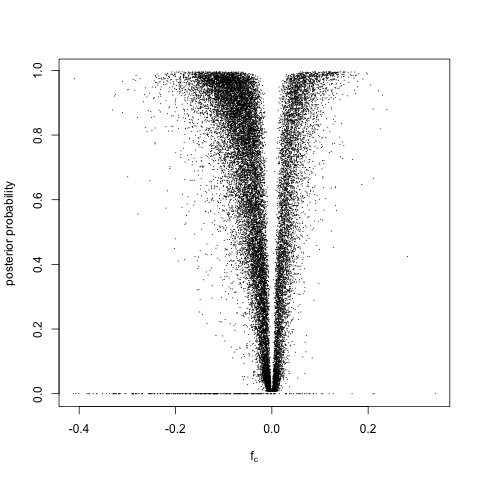

In [25]:
%%R 

plot(fc[!allbad],pp_fc[!allbad],pch=16,cex=0.2,xlab=expression(f["c"]),ylab="posterior probability")

## Plotting Overlapping Histograms of ... Frequency by FC

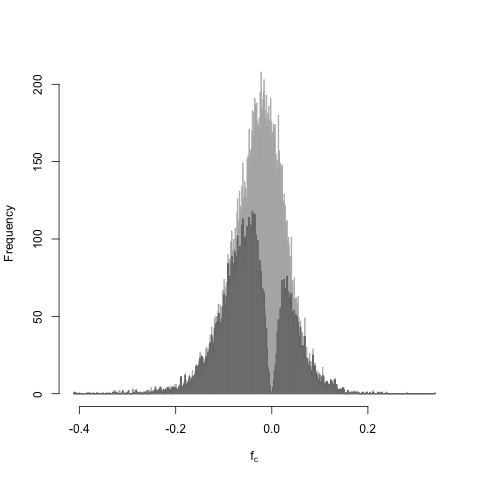

In [26]:
%%R 

plotOverlappingHist <- function(a, b, colors=c("gray70","gray20","gray50"), 
    breaks=NULL, xlim=NULL, ylim=NULL, xlab=NULL,ylab=NULL, main=NULL){
    
   ahist=NULL
   bhist=NULL
   if(!(is.null(breaks))){
      ahist=hist(a,breaks=breaks,plot=FALSE)
      bhist=hist(b,breaks=breaks,plot=FALSE)
   } else {
      ahist=hist(a,plot=FALSE)
      bhist=hist(b,plot=FALSE)
      dist = ahist$breaks[2]-ahist$breaks[1]
      breaks = seq(min(ahist$breaks,bhist$breaks),max(ahist$breaks,bhist$breaks),dist)
      ahist=hist(a,breaks=breaks,plot=FALSE)
      bhist=hist(b,breaks=breaks,plot=FALSE)
   }
 
   if(is.null(xlim)){
      xlim = c(min(ahist$breaks,bhist$breaks),max(ahist$breaks,bhist$breaks))
   }
 
   if(is.null(ylim)){
      ylim = c(0,max(ahist$counts,bhist$counts))
   }
 
   overlap = ahist
   for(i in 1:length(overlap$counts)){
      if(ahist$counts[i] > 0 & bhist$counts[i] > 0){
         overlap$counts[i] = min(ahist$counts[i],bhist$counts[i])
      } else {
         overlap$counts[i] = 0
      }
   }

   plot(ahist, xlim=xlim, ylim=ylim, col=colors[1], border=colors[1],xlab=xlab,ylab=ylab,main=main)
   plot(bhist, xlim=xlim, ylim=ylim, col=colors[2], border=colors[2], add=TRUE)
   plot(overlap, xlim=xlim, ylim=ylim, col=colors[3], border=colors[3], add=TRUE)
}

r<-runif(nn)
fr<-fc[r<pp_fc]
rge<-range(fc)
plotOverlappingHist(fc[!allbad],fr,
    breaks=seq(rge[1]-.001,rge[2]+0.001,by=0.001),
    xlab=expression(f["c"]),ylab="Frequency")

## Making Histograms of Relative Abundance At T0 For Each Replicate

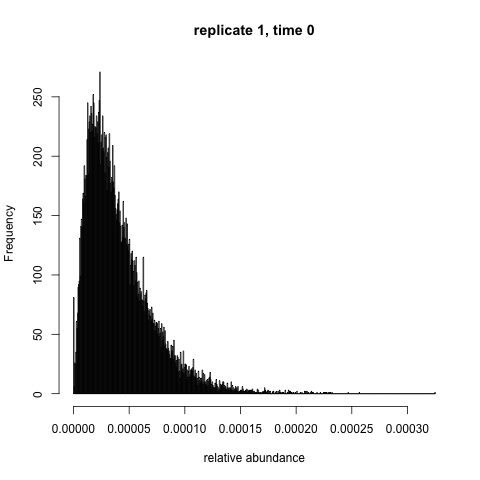

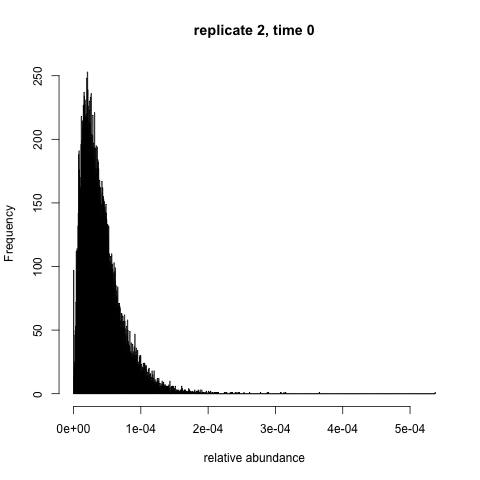

In [27]:
%%R 

names(fc)<-pA_pB
names(pp_fc)<-pA_pB
names(sdfc)<-pA_pB
hist(2^a1,breaks=1000,xlab="relative abundance",main="replicate 1, time 0")
#e1<-ecdf(2^a1)
#plot(e1,xlab="relative abundance",ylab="ecdf",main="replicate 1, time 0")
hist(2^a2,breaks=1000,xlab="relative abundance",main="replicate 2, time 0")
#e2<-ecdf(2^a2)
#plot(e2,xlab="relative abundance",ylab="ecdf",main="replicate 2, time 0")

## Errr ... Setting Initial Weights, Maybe?

Takes a minute ...

In [28]:
%%R 

u1<-rep(0,nn)
names(u1)<-pA_pB
u1[!allbad]<-1  #all other weights set to 1


fc0<-fc
fc_0<-matrix(0,nrow=nprobes,ncol=nprobes)
sdfc_0<-matrix(0,nrow=nprobes,ncol=nprobes)
w0_0<-matrix(0,nrow=nprobes,ncol=nprobes)
pp_0<-matrix(0,nrow=nprobes,ncol=nprobes)
rownames(fc_0)<-probes
colnames(fc_0)<-probes
rownames(sdfc_0)<-probes
colnames(sdfc_0)<-probes
rownames(w0_0)<-probes
colnames(w0_0)<-probes
rownames(pp_0)<-probes
colnames(pp_0)<-probes
for (i in 1:(n-1)) {
   for (k in 1:3) {
      iprobe<-(i-1)*3+k
      iprobe_name<-probes[iprobe]
      for (j in (i+1):n) {
         for (l in 1:3) {
            jprobe<-(j-1)*3+l
            jprobe_name<-probes[jprobe]
            construct<-paste(iprobe_name,"_",jprobe_name,sep="")
            w0_0[iprobe_name,jprobe_name]<-u1[construct] #initial weights. non-existent pairs will have w0=0
            pp_0[iprobe_name,jprobe_name]<-pp_fc[construct] #initial weights. non-existent pairs will have w0=0
            fc_0[iprobe_name,jprobe_name]<-fc0[construct]
            sdfc_0[iprobe_name,jprobe_name]<-sdfc[construct]
         }
      }
   }
}
w0_0<-w0_0+t(w0_0) #make symmetric
fc_0<-fc_0+t(fc_0)
pp_0<-pp_0+t(pp_0)

## Robust Fitting

Printing a bunch of .... what?

In [29]:
%%R 

#robust fitting
res2<-irls(fc_0,w0_0,probes,ag=2,tol=1e-3,maxit=50)

1 0.3567908 0.02872182 
2 0.3478716 0.0174502 
3 0.3437614 0.01307251 
4 0.3422289 0.01133606 
5 0.3421561 0.009601067 
6 0.3426542 0.007264814 
7 0.343023 0.005148175 
8 0.3429778 0.003888621 
9 0.3425708 0.003377016 
10 0.3419478 0.00324043 
11 0.3412225 0.003240698 
12 0.3404615 0.003271521 
13 0.3397018 0.003289718 
14 0.3389641 0.003263157 
15 0.3382626 0.003165731 
16 0.3376091 0.003006403 
17 0.3370091 0.002798842 
18 0.3364648 0.00255833 
19 0.3359763 0.002310294 
20 0.3355402 0.002076285 
21 0.3351513 0.001865624 
22 0.3348047 0.00168143 
23 0.3344956 0.001523152 
24 0.3342198 0.001387338 
25 0.3339734 0.001267053 
26 0.3337535 0.001158576 
27 0.3335572 0.001060624 
28 0.3333816 0.0009716184 


## Setting fp and fc ... whatever those are ...

In [30]:
%%R 

fp<-res2[[1]] #these are probe fitnesses fp
#since fp is determined up to an additive constant, set the constant by 
#requiring that mean(fp[1:3]) = 0 (the null probes have zero fitness
mnull<-mean(fp[1:3])

fp<-fp-mnull
fc<-fc-mnull*2

#now shift a's according to the relation ac<-mx-mt*fc
#end removing freedom
#a, fc, and fp are fully set

## Find Best Probes?

In [31]:
%%R 

rank_p<-rep(0,nprobes)
names(rank_p)<-probes
#find best probes
fp12<-fp
i<-1 #do null construct
rank_p[(i-1)*3+1:3]<-rank(abs(fp12[(i-1)*3+1:3])) #looking for the worst
for (i in 2:n) {
   rank_p[(i-1)*3+1:3]<-rank(-abs(fp12[(i-1)*3+1:3])) #looking for the best
}
p_rank<-3-rank_p
wpi1<-matrix(0,nrow=nprobes,ncol=nprobes)
for (i in 1:nprobes) {
   for (j in 1:nprobes) {
      wpi1[i,j]<-(rank_p[i]-3)*(rank_p[j]-3)
   }
}

## Set ... fmean?

In [32]:
%%R 

f<-rep(0,n)
names(f)<-genes
for (i in 1:n) {
   w1<-(rank_p[(i-1)*3+1:3]-3)^2 #ansatz for weights
   f[i]<-sum(w1*fp[(i-1)*3+1:3])/sum(w1) #weighted mean

}
fmean<-f

## Get Raw Pi Scores Per Construct

In [33]:
%%R 

pi1<-res2[[3]] #raw pi-scores per construct

mean_pi1<-matrix(0,nrow=n,ncol=n)
for (i in 1:(n-1)) {
   ixi<-3*(i-1)+1:3
   for (j in (i+1):n) {
      ixj<-3*(j-1)+1:3
      expressed1<-w0_0[ixi,ixj]>0 #define expressed probe pairs
      local_w1<-wpi1[ixi,ixj]/sum(wpi1[ixi,ixj][expressed1])*sum(expressed1)

      mean_pi1[i,j]<-sum((pi1[ixi,ixj]*wpi1[ixi,ixj])[expressed1])/max(small,sum(wpi1[ixi,ixj][expressed1]))
   }
}
uutri<-upper.tri(mean_pi1)
uutri[1,]<-FALSE #remove top line, 0
zi1<-mean_pi1[uutri]
zi<-zi1
npi<-length(zi1)

## Iterate Over Robust Fitness Calculation

Hmm, takes 15-20 min to run for 1000 iterations on the provided test data

In [34]:
%%R 

mmm<-length(fp)
pi_iter<-matrix(0,nrow=npi,ncol=niter)
fp_iter<-matrix(0,nrow=mmm,ncol=niter)
f_iter<-matrix(0,nrow=n,ncol=niter)
utri<-upper.tri(fc_0)
ntri<-sum(utri)
ppi_iter<-matrix(0,nrow=ntri,ncol=niter)

for (iter in 1:niter) {
   cat("\n",iter,"\n") # AB Printing iteration and spacing lines
   
   fc_1<-matrix(0,nrow=nprobes,ncol=nprobes)
   fc0<-fc_0[utri]+rnorm(ntri,sd=sdfc_0[utri])
#  fc0<-fc_0[utri]
   pp0<-pp_0[utri]
   draw<-ifelse(runif(ntri)<pp0,1,0)
   fc_1[utri]<-fc0*draw
   fc_1<-fc_1+t(fc_1)
   
   #robust fitting
   res2<-irls(fc_1,w0_0,probes,ag=2,tol=1e-3,maxit=50)

   fp0<-res2[[1]] #these are probe fitnesses fp

   #since fp is determined up to an additive constant, set the constant by 
   #requiring that mean(fp[1:3]) = 0 (the null probes have zero fitness

   mnull<-mean(fp0[1:3])
   fp0<-fp0-mnull
   
   for (i in 1:n) {
      w1<-(rank_p[(i-1)*3+1:3]-3)^2 #ansatz for weights
      f_iter[i,iter]<-sum(w1*fp0[(i-1)*3+1:3])/sum(w1) #weighted mean
   }
   
   pi1<-res2[[3]] #raw pi-scores per construct
   pi_scrambled<-pi1
#  upi1<-pi1[utri]
#  ppi_iter[,iter]<-upi1
#  upi1<-sample(upi1) #BOOM
#  pi_scrambled<-matrix(0,nrow=nprobes,ncol=nprobes)
#  pi_scrambled[utri]<-upi1
#  pi_scrambled<-pi_scrambled+t(pi_scrambled)
   
   mean_pi1<-matrix(0,nrow=n,ncol=n)
   for (i in 1:(n-1)) {
      ixi<-3*(i-1)+1:3
      for (j in (i+1):n) {
         ixj<-3*(j-1)+1:3
         expressed1<-w0_0[ixi,ixj]>0 #define expressed probe pairs
         local_w1<-wpi1[ixi,ixj]/sum(wpi1[ixi,ixj][expressed1])*sum(expressed1)
   
         mean_pi1[i,j]<-sum((pi_scrambled[ixi,ixj]*wpi1[ixi,ixj])[expressed1])/max(small,sum(wpi1[ixi,ixj][expressed1]))
      }
   }
   zi1<-mean_pi1[uutri]
   
   pi_iter[,iter]<-zi1
   fp_iter[,iter]<-fp0
}


 1 
1 0.2785853 0.09358917 
2 0.1969859 0.05006766 
3 0.1533895 0.02523048 
4 0.1325586 0.012217 
5 0.1230572 0.006262171 
6 0.1186512 0.003474767 
7 0.1165349 0.002018001 
8 0.1154765 0.001196114 
9 0.1149235 0.0007153216 

 2 
1 0.2838368 0.09005539 
2 0.2072922 0.04961016 
3 0.1642832 0.02758198 
4 0.1416728 0.01539998 
5 0.1302174 0.009311307 
6 0.1244158 0.006047662 
7 0.1214485 0.003974404 
8 0.1199141 0.002571013 
9 0.1191066 0.001629901 
10 0.118672 0.001016804 
11 0.118432 0.0006269498 

 3 
1 0.2883794 0.08899758 
2 0.2126697 0.04905333 
3 0.1687344 0.02882642 
4 0.144796 0.01573544 
5 0.1329427 0.008015834 
6 0.1272444 0.004037842 
7 0.124449 0.002104201 
8 0.1230194 0.001168962 
9 0.1222501 0.0007127363 

 4 
1 0.2766765 0.09145243 
2 0.1974602 0.04693858 
3 0.1554043 0.02557348 
4 0.1333965 0.01505794 
5 0.1221353 0.008913274 
6 0.1165642 0.005089884 
7 0.1138225 0.002876309 
8 0.1124279 0.001674944 
9 0.111679 0.001037811 
10 0.1112518 0.0006873498 

 5 
1 0.2811145 0.08

## Get Means and SDs

In [35]:
%%R 

f_mean<-apply(f_iter,1,mean)
f_sd<-apply(f_iter,1,sd)
#plot(f_mean,f_sd,pch=".",cex=2)

fp_mean<-apply(fp_iter,1,mean)
fp_sd<-apply(fp_iter,1,sd)
#plot(fp_mean,fp_sd)

#pi_mean<-apply(pi_iter,1,mean)
pi_mean<-apply(pi_iter,1,mean)
pi_sd<-apply(pi_iter,1,sd)

## No Idea Whatsoever

In [36]:
%%R 

pi_iter_null<-pi_iter-pi_mean
pi_null<-c(pi_iter_null,-pi_iter_null)
enull<-ecdf(pi_null)
emean<-ecdf(pi_mean)

## Plot Histograms of Pi Scores?

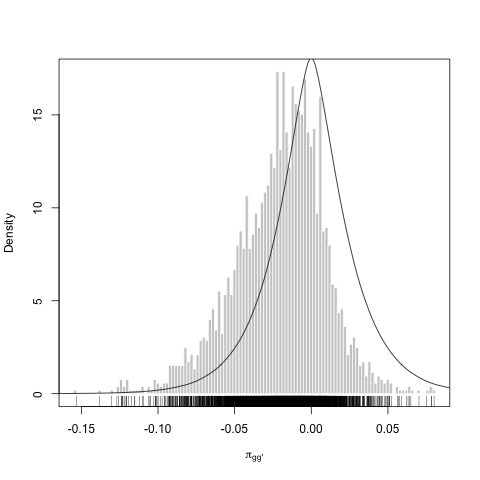

In [37]:
%%R 

rge<-range(pi_mean)
h<-hist(pi_mean,breaks=seq(rge[1]-0.002,rge[2]+0.002,by=0.002),
    main="",xlab=expression(pi["gg'"]),col="grey80",border=FALSE,probability=TRUE)

d<-density(pi_null,bw=0.002)
lines(d,col="black")
rug(pi_mean)
box()

## Set FDR Left and FDR Right

In [38]:
%%R 

fdr_left<-pmin(1,enull(pi_mean)/emean(pi_mean))
fdr_right<-pmin(1,(enull(-pi_mean))/(1-emean(pi_mean)))

## Plot Left Tail Test

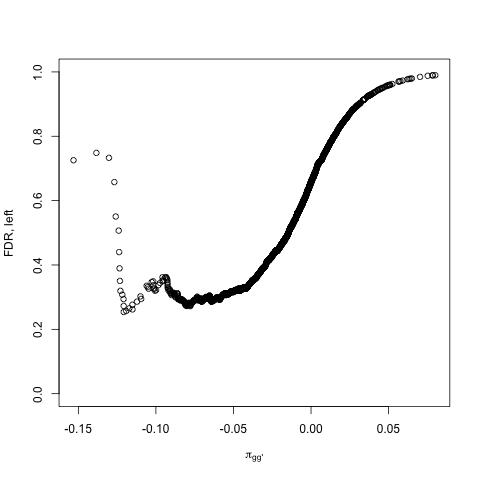

In [39]:
%%R 

plot(pi_mean,fdr_left,ylim=c(0,1),xlab=expression(pi["gg'"]),ylab="FDR, left") #left tail test

## Plot Right Tail Test

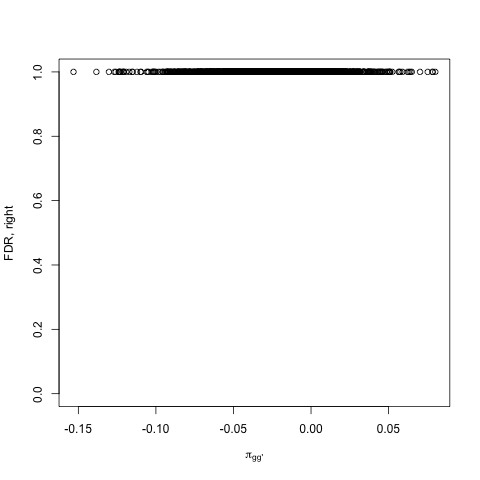

In [40]:
%%R 

plot(pi_mean,fdr_right,ylim=c(0,1),xlab=expression(pi["gg'"]),ylab="FDR, right") #right tail test

## Construct and Write Out Pi Score Table

In [41]:
%%R 

# AB Errr ... setting up empty matrices?
# AB Reminder: n = number of genes
g1names<-matrix("",ncol=n,nrow=n)
g2names<-matrix("",ncol=n,nrow=n)
ggnames<-matrix("",ncol=n,nrow=n)

# AB Reminder: genes = all gene symbols in alphabetical order
# AB i = 1 to 2nd to last gene index (1-based)
# AB j is always 1 more than i
# AB Generate gene pair names and store in a symmetric matrix?
for (i in 1:(n-1)) {
   for (j in (i+1):n) {
      g1names[i,j]<-genes[i]
      g2names[i,j]<-genes[j]
      ggnames[i,j]<-paste(genes[i],"_",genes[j],sep="")
      ggnames[j,i]<-ggnames[i,j]
   }
}

z<-pi_mean/sd(pi_mean)

pi_iter_null<-pi_iter-pi_mean
abspi<-abs(pi_mean)
PP<-apply(abs(pi_iter_null)<abspi,1,mean)

#oPP<-order(abspi,decreasing=TRUE)
oPP<-order(z)

#who are these gene pairs?
names_of_g1<-g1names[uutri]
fg1<-f[names_of_g1]
names_of_g2<-g2names[uutri]
fg2<-f[names_of_g2]
fg12<-fg1+fg2
names_of_gg<-ggnames[uutri]

#res<-data.frame(names_of_gg,names_of_g1,fg1,names_of_g2,fg2,fg12,zi,pi_sd,pi_pp)

res<-data.frame(names_of_gg,names_of_g1,fg1,names_of_g2,fg2,fg12,pi_mean,pi_sd,PP,abspi,fdr_left,fdr_right,z)
colnames(res)<-c("gene_gene","geneA","fA","geneB","fB","fA+fB","pi","sd","PP","abs pi","FDR left","FDR right","z")
write.table(res[oPP,],file=paste(project,"_pi.txt",sep=""),sep="\t",row.names=FALSE,quote=FALSE)

## Plot Fit of Log2 Relative Frequency 

In [ ]:
%%R 

plot_fit<-function(x1,ac1,fc1,ab1,x2,ac2,fc2,ab2,minfc=0.10) {

   nx<-nrow(x1)
   maxt<-time[nt]+3
   plot_lambda1<-rep(0,maxt)
   plot_lambda2<-rep(0,maxt)

   good1<-t(t(x1)>ab1)
   good2<-t(t(x2)>ab2)
   allbad<-apply(good1,1,sum)<2 & apply(good2,1,sum)<2 #in this case I have nothing to use in either experiment

   for (i in 1:maxt) plot_lambda1[i]<- -log2(sum(2^(ac1+fc1*i)))
   for (i in 1:maxt) plot_lambda2[i]<- -log2(sum(2^(ac2+fc2*i)))
   
   rge<-range(c(x1,x2))
   for (i in 1:nx) {
      if (allbad[i]) next
      if (abs(fc1[i])<minfc & abs(fc2[i])<minfc) next
      pch<-rep(1,nt)
      pch[good1[i,]]<-16 #circle
      plot(time,x1[i,],ylim=rge,pch=pch,cex=1.2,main=pA_pB[i],xlab="time",ylab=expression(paste(log[2]," relative frequency")))
      yfit<-ac1[i]+fc1[i]*(1:maxt)+plot_lambda1
      lines(1:maxt,yfit)

      pch<-rep(1,nt)
      pch[good2[i,]]<-16 
      points(time,x2[i,],pch=pch,cex=1.2,col="blue")
      yfit<-ac2[i]+fc2[i]*(1:maxt)+plot_lambda2
      lines(1:maxt,yfit,col="blue")
   }
}

plot_fit(x1,a1,fc,ab1,x2,a2,fc,ab2,minfc=0.10)

## Write out FCs

In [ ]:
%%R 

resp<-data.frame(pA_pB,fc,sdfc)
write.table(resp,file=paste(project,"_fc.txt",sep=""),sep="\t",row.names=FALSE,quote=FALSE)

## Absolutely No Idea

In [ ]:
%%R 



## Plot Histograms of Construct Fitness?

In [ ]:
%%R 

rge<-range(fc)
hh<-hist(fc[!allbad],breaks=seq(rge[1]-0.005,rge[2]+0.005,by=0.005),
    main="construct fitness",col="grey80",border=FALSE,xlab=expression(f["c"]))
d<-density(fc[!allbad],bw=0.01)
lines(d$x,d$y*sum(hh$counts)*0.005,col="black")

rug(fc[!allbad])
abline(h=0)

## Plot Scatterplots (of?)

In [ ]:
%%R 

plot_scatterplots<-function() {

    #now plot fitted value scatterplots
    fit_x1<-matrix(0,nrow=nn,ncol=nt)
    fit_x2<-matrix(0,nrow=nn,ncol=nt)
    for (j in 1:nt) {
       fit_x1[,j]<-2^(a1+fc*time[j])
       fit_x2[,j]<-2^(a2+fc*time[j])
    }
    fit_x1[bad1,]<-0 #remove missing constructs
    fit_x2[bad2,]<-0
    ab1<-apply(fit_x1,2,sum)
    ab2<-apply(fit_x2,2,sum)
    fit_x1<-t(t(fit_x1)/ab1) #take ratio to get fitted x_c values
    fit_x2<-t(t(fit_x2)/ab2)
    fit_x1[!bad1,]<-log2(fit_x1[!bad1,])
    fit_x2[!bad2,]<-log2(fit_x2[!bad2,])
    fit_x1[bad1,]<-0 #remove missing constructs
    fit_x2[bad2,]<-0


    #plot experimental values
    for (i in 2:nt) {
       smoothScatter(x1[!bad1,c(1,i)],xlim=c(-17,-11),ylim=c(-17,-11),transformation = function(x) {log2(x+1)^.75},pch=16,cex=0.4,xlab=paste("log2 frequency, d",time[1],sep=""),ylab=paste("log2 frequency, d",time[i],sep=""),main="experimental log2 frequencies, replicate 1")
       abline(0,1,col="#000066")
       a<-(x1[!bad1,i]+x1[!bad1,1])/2
       m<-(x1[!bad1,i]-x1[!bad1,1])
       smoothScatter(a,m,xlim=c(-17,-11),ylim=c(-10,10),transformation = function(x) {log2(x+1)^.75},pch=16,cex=0.4,main=paste("experimental log2 frequencies, replicate 1, d",time[1],"-d",time[i],sep=""))
       abline(h=0,col="#000066")
       yl<-lowess(a,m,f=0.2)
       lines(yl,col="red")
    }
    for (i in 2:nt) {
       smoothScatter(x2[!bad2,c(1,i)],xlim=c(-17,-11),ylim=c(-17,-11),transformation = function(x) {log2(x+1)^.75},pch=16,cex=0.4,xlab=paste("log2 frequency, d",time[1],sep=""),ylab=paste("log2 frequency, d",time[i],sep=""),main="experimental log2 frequencies, replicate 2")
       abline(0,1,col="#000066")
       a<-(x2[!bad2,i]+x2[!bad2,1])/2
       m<-(x2[!bad2,i]-x2[!bad2,1])
       smoothScatter(a,m,xlim=c(-17,-11),ylim=c(-10,10),transformation = function(x) {log2(x+1)^.75},pch=16,cex=0.4,main=paste("experimental log2 frequencies, replicate 2, d",time[1],"-d",time[i],sep=""))
       abline(h=0,col="#000066")
       yl<-lowess(a,m,f=0.2)
       lines(yl,col="red")
    }

    #now plot fitted values
    for (i in 2:nt) {
       smoothScatter(fit_x1[!bad1,c(1,i)],xlim=c(-17,-11),ylim=c(-17,-11),transformation = function(x) {log2(x+1)^.75},pch=16,cex=0.4,xlab=paste("log2 frequency, d",time[1],sep=""),ylab=paste("log2 frequency, d",time[i],sep=""),main="fitted frequencies, replicate 1")
       abline(0,1,col="#000066")
       a<-(fit_x1[!bad1,i]+fit_x1[!bad1,1])/2
       m<-(fit_x1[!bad1,i]-fit_x1[!bad1,1])
       smoothScatter(a,m,xlim=c(-17,-11),ylim=c(-10,10),transformation = function(x) {log2(x+1)^.75},pch=16,cex=0.4,main=paste("fitted log2 frequencies, replicate 1, d",time[1],"-d",time[i],sep=""))
       abline(h=0,col="#000066")
       yl<-lowess(a,m,f=0.2)
       lines(yl,col="red")
    }
    for (i in 2:nt) {
       smoothScatter(fit_x2[!bad2,c(1,i)],xlim=c(-17,-11),ylim=c(-17,-11),transformation = function(x) {log2(x+1)^.75},pch=16,cex=0.4,xlab=paste("log2 frequency, d",time[1],sep=""),ylab=paste("log2 frequency, d",time[i],sep=""),main="fitted frequencies, replicate 2")
       abline(0,1,col="#000066")
       a<-(fit_x2[!bad2,i]+fit_x2[!bad2,1])/2
       m<-(fit_x2[!bad2,i]-fit_x2[!bad2,1])
       smoothScatter(a,m,xlim=c(-17,-11),ylim=c(-10,10),transformation = function(x) {log2(x+1)^.75},pch=16,cex=0.4,main=paste("fitted log2 frequencies, replicate 1, d",time[1],"-d",time[i],sep=""))
       abline(h=0,col="#000066")
       yl<-lowess(a,m,f=0.2)
       lines(yl,col="red")
    }

    #now cross-plots at times 1 2 3..
    for (i in 1:nt) {
       smoothScatter(x1[good,i],x2[good,i],xlim=c(-17,-11),ylim=c(-17,-11),transformation = function(x) {log2(x+1)^.75},pch=16,cex=0.4,xlab=paste("replicate 1, d",time[i],sep=""),ylab=paste("replicate 2, d",time[i],sep=""),main=paste("comparison of experimental replicates, d",time[i],sep=""))
    abline(0,1,col="#000066")
    }
    for (i in 1:nt) {
       smoothScatter(fit_x1[good,i],fit_x2[good,i],xlim=c(-17,-11),ylim=c(-17,-11),transformation = function(x) {log2(x+1)^.75},pch=16,cex=0.4,xlab=paste("replicate 1, d",time[i],sep=""),ylab=paste("replicate 2, d",time[i],sep=""),main=paste("comparison of fitted replicates, d",time[i],sep=""))
    abline(0,1,col="#000066")
    }
}


plot_scatterplots()

## Plot FP for Each N (Whatever That Means ...)

In [ ]:
%%R 

rge<-range(fp)
for (i in 1:n) {
   plot(fp,fp,xlim=rge,ylim=rge,main=genes[i])
   abline(h=0,v=0)
   points(fp[(i-1)*3+1:3],fp[(i-1)*3+1:3],pch=16,col="red")
}

## Write Out Ps

In [ ]:
%%R 

resp<-data.frame(probes,p_rank)
write.table(resp,file=paste(project,"_p.txt",sep=""),sep="\t",row.names=FALSE,quote=FALSE)

## Write Out Fs

In [ ]:
%%R 

resy<-data.frame(genes,f,f_sd)
colnames(resy)<-c("gene","f","sd")
write.table(resy[-1,],file=paste(project,"_f.txt",sep=""),sep="\t",row.names=FALSE,quote=FALSE)

## Plot Single Gene Fitnesses

In [ ]:
%%R 

rge<-range(f)*1.1 #with some margin
plot(f[-1],f[-1],pch=16,cex=0.6,col="blue",
     xlim=rge,ylim=rge,xlab=expression(f["g"]),
     ylab=expression(f["g"]),main="single-gene fitness")
abline(v=0,h=0,col="#000066")
text(f[-1],f[-1],cex=0.6,labels=genes[-1],pos=((rank(f[-1]) %% 2)+1)*2,offset=0.2)

In [ ]:
#%R dev.off()